In [373]:
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import seaborn as sns

In [379]:
# data_fp = '/bsuhome/zacharykeskinen/spicy-snow/data/res_ds_iter.nc'
data_fp = '/bsuhome/zacharykeskinen/spicy-snow/data/res_ds_iter.nc'

ds = xr.open_dataset(data_fp)

In [381]:
ds['pearsonr'].argmin(['A', 'B', 'C', 'iteration'])

{'A': <xarray.DataArray 'pearsonr' (location: 9)>
 array([4, 2, 0, 1, 3, 4, 1, 4, 2])
 Coordinates:
   * location  (location) object 'Mores_2021-03-15' ... 'Frasier_2020-02-11',
 'B': <xarray.DataArray 'pearsonr' (location: 9)>
 array([7, 6, 8, 3, 1, 7, 9, 1, 9])
 Coordinates:
   * location  (location) object 'Mores_2021-03-15' ... 'Frasier_2020-02-11',
 'C': <xarray.DataArray 'pearsonr' (location: 9)>
 array([99, 36,  8, 74, 31, 52, 64, 85, 29])
 Coordinates:
   * location  (location) object 'Mores_2021-03-15' ... 'Frasier_2020-02-11',
 'iteration': <xarray.DataArray 'pearsonr' (location: 9)>
 array([90, 99, 89, 95, 62, 22, 91, 62, 88])
 Coordinates:
   * location  (location) object 'Mores_2021-03-15' ... 'Frasier_2020-02-11'}

In [431]:
a

<xarray.Dataset>
Dimensions:    (location: 9, A: 5, C: 100, iteration: 100)
Coordinates:
  * location   (location) object 'Banner_2020-02-18' ... 'Cameron_2021-03-19'
  * A          (A) float64 1.0 1.5 2.0 2.5 3.0
    B          (location, A, C, iteration) float64 0.0 0.0 0.0 ... 0.7 1.0 1.0
  * C          (C) float64 0.01 0.02 0.03 0.04 0.05 ... 0.96 0.97 0.98 0.99 1.0
  * iteration  (iteration) int64 0 1 2 3 4 5 6 7 8 ... 92 93 94 95 96 97 98 99
Data variables:
    pearsonr   (location, A, C, iteration) float64 0.3314 0.3216 ... 0.03042
    mae        (location, A, C, iteration) float64 1.499 1.499 ... 1.565 1.579

/tmp/ipykernel_24750/3696028645.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/tmp/ipykernel_24750/3696028645.py:66: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


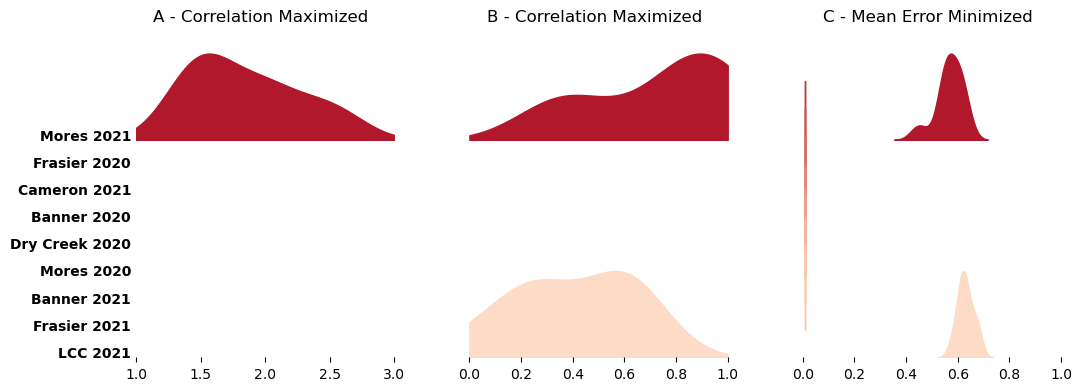

In [467]:
import matplotlib.gridspec as grid_spec
from matplotlib import colormaps
cmap = colormaps.get_cmap('RdBu')
colors = cmap(np.linspace(0.1, 0.4, len(ds.location)))

fig = plt.figure(layout='constrained', figsize=(10, 4))
subfigs = fig.subfigures(1, 3, wspace=0.07)
params = ['A', 'B', 'C']

sorted = res_ds.reindex(location = res_ds['pearsonr'].isel(res_ds['pearsonr'].argmin(['A', 'C'])).idxmin('B').mean('iteration').to_dataframe().sort_values('B').to_xarray().location[::-1])

clips = [[1, 3], [0, 1], [0, 1]]

param_stat = {'A':'pearsonr', 'B':'pearsonr', 'C':'mae'}

for i, (param, subfig, clip,) in enumerate(zip(params, subfigs, clips)):
    axes = subfig.subplots(len(ds.location), gridspec_kw = {'hspace': -0.7})
    other_params = params[:]
    other_params.remove(param)

    stat_name = param_stat[param]

    for loc, color, ax in zip(sorted.location, colors, axes):
        
        param_1, param_2 = other_params
        a = sorted.loc[{param_1 : sorted[param_stat[param_1]].idxmax(param_1)}]
        if param_2 == 'C':
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmin(param_2)}]
        else:
            data = a.loc[{param_2 : a[param_stat[param_2]].idxmax(param_2)}]
        
        if param == 'C':
            data = data.idxmin(param)
        else:
            data = data.idxmax(param)
        
        data = data.sel(location = loc)
        
        data = data[param_stat[param]].data
        # data = data + np.random.random(data.shape)/1000

        sns.kdeplot(data, color = color, \
                    fill = True, alpha = 1.0, ax= ax, clip = clip, warn_singular=False, zorder = 1)
        ax.set_xlim(clip)
        ax.set_yticks([])
        ax.set_ylabel('')

        rect = ax.patch
        rect.set_alpha(0)

        spines = ["top", "right", "left", "bottom"]
        for s in spines:
            ax.spines[s].set_visible(False)
        
        if i == 0:
            site_name = str(loc.data).replace('_', ' ').replace('Little Cottonwood', 'LCC').split('-')[0]
            ax.text(-0.02, 0, site_name, fontweight = 'bold', ha = 'right', transform = ax.transAxes, zorder = 1e5)


    for ax in axes[:-1]:
        ax.set_xticks([])

    stat_title= {'mae':'Mean Error Minimized', 'pearsonr':'Correlation Maximized'}
    subfig.suptitle(f'{param} - {stat_title[param_stat[param]]}')

plt.tight_layout()

In [473]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

from pathlib import Path
from tqdm import tqdm

from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error

# from itertools import product
from tqdm.contrib.itertools import product

def get_stats(a, b):
    r, p = pearsonr(a, b)
    error = mae(a, b)
    rmse = mean_squared_error(a, b, squared=False)
    return r, error, rmse

res_fp = Path('/bsuhome/zacharykeskinen/spicy-snow/data/res_ds_iter_fast_v2.nc')

if res_fp.exists():
    print('Already exists...')
    res_ds = xr.load_dataset(res_fp)

else:
    param_fp = Path('/bsuhome/zacharykeskinen/scratch/param_regional')

    locs = list(param_fp.glob('*'))
    locs = [l.stem for l in locs]
    # Create parameter space
    A = np.round(np.arange(1, 3.1, 0.5), 2)
    B = np.round(np.arange(0, 1.01, 0.1), 2)
    C = np.round(np.arange(0.01, 1.001, 0.01), 2)
    iterations = np.arange(10)
    res = np.zeros((len(locs), len(A), len(B), len(C), len(iterations)))


    da = xr.DataArray(res, coords = [locs, A, B, C, iterations], dims = ['location', 'A', 'B','C', 'iteration'], name = 'pearsonr')
    res_ds = xr.merge([da, da.copy().rename('mae'), da.copy().rename('rmse')])

    for loc_fp in param_fp.glob('*'):
        print(loc_fp)
        lidar_orig = np.load(loc_fp.joinpath('lidar.npy'))
        for a, b, c in product(A, B, C, miniters = 500):
            sds_orig = np.load(loc_fp.joinpath(f'{a}_{b}_{c}.npy'))
            combo = np.vstack([lidar_orig, sds_orig])
            for iter in iterations:
                idx = np.random.choice(combo.shape[1], combo.shape[1], replace = True)
                sds, lidar = combo.T[idx].T
                r, mean_error, rmse = get_stats(lidar, sds)
                res_ds['pearsonr'].loc[dict(location = loc_fp.stem, A = a, B = b, C = c, iteration = iter)] = r
                res_ds['mae'].loc[dict(location = loc_fp.stem, A = a, B = b, C = c, iteration = iter)] = mean_error
                res_ds['rmse'].loc[dict(location = loc_fp.stem, A = a, B = b, C = c, iteration = iter)] = rmse
                print(c)
                print(np.mean(sds))
                print(np.mean(lidar))
                print('----')
    # res_ds.to_netcdf(res_fp)

/bsuhome/zacharykeskinen/scratch/param_regional/Mores_2021-03-15


  0%|          | 0/5500 [00:00<?, ?it/s]

0.01
1.6101705351090576
0.013629925504448115
----
0.01
1.5924125223091707
0.013494132667936202
----
0.01
1.609165549867432
0.013944979261041312
----
0.01
1.603293170122443
0.013933247143519864
----
0.01
1.6106073001398613
0.013697157478770159
----
0.01
1.5975879415714236
0.013755064195049127
----
0.01
1.626778968672776
0.014226554411346428
----
0.01
1.5872046582192134
0.013659304569883257
----
0.01
1.5982510830137115
0.013899958068815454
----
0.01
1.6089724227008684
0.013972784741912386
----
0.02
1.6171943375463345
0.02777358914238544
----
0.02
1.6309095170064525
0.027405689176825232
----
0.02
1.5989399993242894
0.027478076679718036
----
0.02
1.6064300620902836
0.0276149909781596
----
0.02
1.6193341543751716
0.028055019421350795
----
0.02
1.6142413219470757
0.02772789905926009
----
0.02
1.6094422358722886
0.027558160356644153
----
0.02
1.6034560310912618
0.02809310414167414
----
0.02
1.6135527408103376
0.0275191593997835
----
0.02
1.6104500700915534
0.027883609646450074
----
0.03
1.604

  9%|▉         | 500/5500 [00:08<01:28, 56.26it/s]

0.9
1.6109265197050042
1.1867407427103875
----
0.9
1.6253784783000411
1.1817650510334667
----
0.9
1.6300503659025776
1.2109861976942415
----
0.9
1.6106243269709295
1.1941339211435011
----
0.9
1.5888202966797949
1.1629531528624009
----
0.9
1.6004235122571733
1.176956052575268
----
0.9
1.6116748288200164
1.220340121445063
----
0.91
1.6167867996743719
1.2187407422090477
----
0.91
1.6152841818326125
1.2207561884752682
----
0.91
1.6057417155752334
1.1908934374983406
----
0.91
1.6076551224752025
1.1996728656532207
----
0.91
1.6229522554249898
1.2059440331381484
----
0.91
1.5984097878269152
1.2090788207846344
----
0.91
1.6110933357251338
1.2054916978605787
----
0.91
1.61849484556262
1.2256018849768961
----
0.91
1.5902105977677958
1.195257778735182
----
0.91
1.6141912804927752
1.218319992078082
----
0.92
1.6094343257696664
1.2286355896855785
----
0.92
1.6136322105277836
1.2120089952268103
----
0.92
1.6049633748841639
1.2067658372308785
----
0.92
1.6035711968226594
1.2291052729477059
----
0.92


 15%|█▌        | 825/5500 [00:14<01:23, 56.19it/s]

0.2
1.6141608802254943
0.2838951819997615
----
0.2
1.6071460604471273
0.2862113437883339
----
0.2
1.596222443347577
0.2831541182335128
----
0.2
1.616211406743376
0.2845521097762822
----
0.2
1.6102724614737782
0.2858254684201728
----
0.2
1.608835236048188
0.2813119308179926
----
0.21
1.6144747705265823
0.29884299396333913
----
0.21
1.6108942424642194
0.29647046480251954
----
0.21
1.6043725304391474
0.2966034451739526
----
0.21
1.6023050106075818
0.29272427688654434
----
0.21
1.6063680214125138
0.2920958085910931
----
0.21
1.6105376845333093
0.29957434001736555
----
0.21
1.6152810982332853
0.30238523361639086
----
0.21
1.6150145344783944
0.2980143700619533
----
0.21
1.5931544966386086
0.3016128210761544
----
0.21
1.6138579165915876
0.3020800637157418
----
0.22
1.621229528922553
0.31590226157768797
----
0.22
1.6054763919635502
0.30922188051483057
----
0.22
1.6003756829502163
0.314285028882961
----
0.22
1.6090543727047295
0.3185167081974125
----
0.22
1.602918915012785
0.31521565704855625
-

KeyboardInterrupt: 